In [131]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.gmm.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GT rule probs:  tensor([0.4444, 0.4444, 0.1111], grad_fn=<DivBackward0>)
GT Mode 0: [-1. -1. -1.] +/- [0.1 0.1 0.1]
GT Mode 1: [1. 1. 1.] +/- [0.2 0.2 0.2]
GT Mode 2: [ 3. -3.  3.] +/- [0.5 0.5 0.5]
GT rule probs:  tensor([0.6876, 0.1652, 0.1472], grad_fn=<DivBackward0>)
Pre-fit Mode 0: [1.49683154 0.4827153  1.63737881] +/- [8.53224089 7.39703052 7.53380901]
Pre-fit Mode 1: [ 0.85255313  0.04037888 -1.8335104 ] +/- [4.05126131 5.57680109 6.94749774]
Pre-fit Mode 2: [ 0.93853496 -1.73393131 -0.781713  ] +/- [4.22886668 9.62792173 4.71348741]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

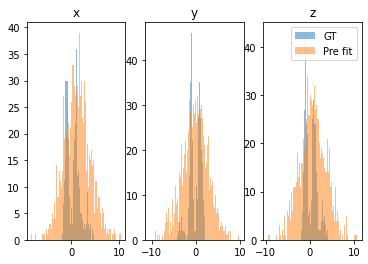

In [132]:
# Make the ground truth GMM grammar.
gt_grammar =SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
# Reset params to values we control (different from prior).
desired_mode_means = [
    torch.tensor([-1., -1., -1.]),
    torch.tensor([1., 1., 1.]),
    torch.tensor([3., -3., 3.])
]
desired_mode_vars = [
    torch.tensor([0.1, 0.1, 0.1]),
    torch.tensor([0.2, 0.2, 0.2]),
    torch.tensor([0.5, 0.5, 0.5])
]
desired_mode_weights = torch.tensor([0.4, 0.4, 0.1])
rule_probs_param = gt_grammar.params_by_node_type[Root.__name__]
rule_probs_param.set(desired_mode_weights)
print("GT rule probs: ", rule_probs_param())
for k, mode in enumerate(Modes):
    mode_name = mode.__name__
    mean_param = gt_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
    mean_param.set(desired_mode_means[k])
    var_param = gt_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
    var_param.set(desired_mode_vars[k])
    print("GT Mode %d: %s +/- %s" % (k, mean_param().detach().numpy(), var_param().detach().numpy()))

# Make our fitting grammar. This'll also have randomly sampled means + vars, but
# different ones.
torch.random.manual_seed(40)
fit_grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
pre_fit_grammar = deepcopy(fit_grammar)
rule_probs_param = pre_fit_grammar.params_by_node_type[Root.__name__]
print("GT rule probs: ", rule_probs_param())
for k, mode in enumerate(Modes):
    mode_name = mode.__name__
    mean_param = fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]().detach().numpy()
    var_param = fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]().detach().numpy()
    print("Pre-fit Mode %d: %s +/- %s" % (k, mean_param, var_param))


def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)

# Draw random samples from our randomly-initialized GMM
def get_draws_from_grammar(grammar, N_samples):
    samples = []
    for k in tqdm(range(N_samples)):
        tree = grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))
    return samples

gt_samples = get_draws_from_grammar(gt_grammar, 1000)
pre_fit_samples = get_draws_from_grammar(fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_pre_fit = get_all_node_xyzs([sample[0] for sample in pre_fit_samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5)
    plt.hist(l_pre_fit[:, k], bins=100, label="Pre fit", alpha=0.5)
    plt.title(label)
    if k == 2:
        plt.legend()
        

In [146]:
torch.random.manual_seed(42)
N_fit_samples = 100

# Draw an actual fitting dataset and do fitting.
samples = get_draws_from_grammar(gt_grammar, N_fit_samples)
svi = SVIWrapper(fit_grammar, [sample[1] for sample in samples])
svi.do_iterated_vi_fitting(major_iterations=20, minor_iterations=25, base_lr=0.1, tqdm=tqdm, num_elbo_samples=1, clip=None)

  0%|          | 0/100 [00:00<?, ?it/s]

Major iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Mode  <class 'spatial_scene_grammars_examples.gmm.grammar.GaussianMode_0'>


0:xyz:mean final: tensor([0.0534, 0.0210, 0.0211])
0:xyz:variance final: tensor([1.2837, 1.1922, 1.0908])
Mode  <class 'spatial_scene_grammars_examples.gmm.grammar.GaussianMode_1'>


0:xyz:mean final: tensor([ 3.2749, -2.5197,  2.7010])
0:xyz:variance final: tensor([0.0271, 0.3685, 0.0661])
Mode  <class 'spatial_scene_grammars_examples.gmm.grammar.GaussianMode_2'>


0:xyz:mean final: tensor([ 3.5654, -2.8107,  2.9503])
0:xyz:variance final: tensor([0.4665, 0.1564, 0.2919])


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

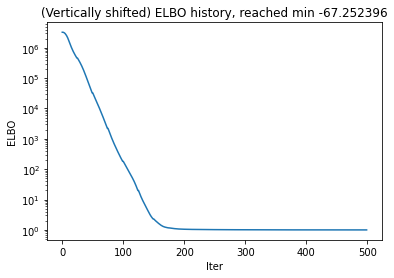

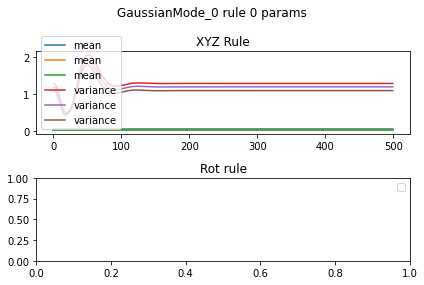

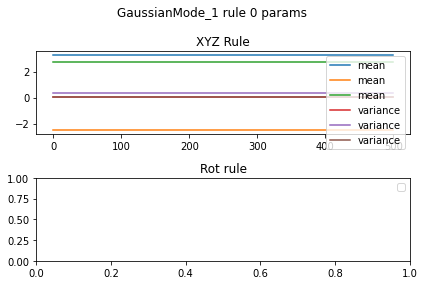

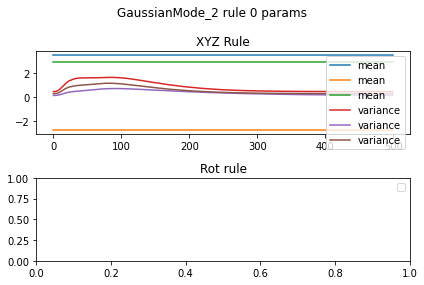

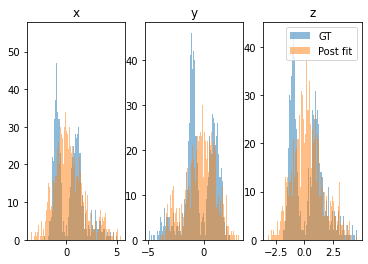

In [148]:
svi.plot_elbo_history()
for mode in Modes:
    print("Mode " , mode)
    svi.plot_grammar_parameter_history(mode)
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
fit_samples = get_draws_from_grammar(fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_fit = get_all_node_xyzs([sample[0] for sample in fit_samples], Point)
plt.figure()
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5)
    plt.hist(l_fit[:, k], bins=100, label="Post fit", alpha=0.5)
    plt.title(label)
    if k == 2:
        plt.legend()

EM fit rule probs:  tensor([0.1100, 0.4400, 0.4500], grad_fn=<DivBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([ 3.5654, -2.8107,  2.9503], requires_grad=True) +/- tensor([0.4662, 0.1390, 0.2916], grad_fn=<AddBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([-1.0271, -1.0086, -0.9721], requires_grad=True) +/- tensor([0.1106, 0.0927, 0.0935], grad_fn=<AddBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([1.1098, 1.0277, 0.9922], requires_grad=True) +/- tensor([0.1733, 0.2173, 0.1585], grad_fn=<AddBackward0>)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

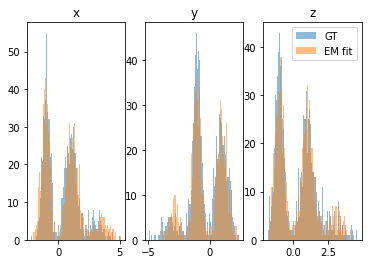

In [145]:
# Hand-written EM baseline for GMM: estimate cluster
# association weights, and then apply a closed form update
# to get new best cluster mean and vars. (Like a "soft"
# k-mean.)

# Initialize param guesses from pre-fit grammar
param_guesses = {
    "mode_weights": pre_fit_grammar.params_by_node_type[Root.__name__]()
}
for mode in Modes:
    mode_name = mode.__name__
    mean = pre_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]().detach()
    var = pre_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]().detach()
    param_guesses[mode_name] = {
        "mean": mean,
        "var": var
    }

N_iters = 50
points = torch.stack([sample[1][0].translation for sample in samples]) # N x 3
for iter_k in range(N_iters):
    # Associate each sample with the MAP cluster
    dists = [
        dist.Normal(
            param_guesses[mode.__name__]["mean"],
            param_guesses[mode.__name__]["var"])
        for mode in Modes
    ]
    # Get scores for each mode for each point.
    point_log_probs = torch.stack([
        dist.log_prob(points).sum(axis=1) for dist in dists
    ], axis=-1) # N x N_dists
    # Multiply in prob of that cluster being active
    point_log_probs = point_log_probs + param_guesses["mode_weights"]
    # Normalize for a given point
    point_log_probs = (point_log_probs.T - torch.logsumexp(point_log_probs, axis=-1)).T
    w = torch.exp(point_log_probs)
    
    # New weight guesses are average of weights
    param_guesses["mode_weights"] = torch.mean(w, axis=0)
    # New mean is weighted sum of observed locations
    for k, mode in enumerate(Modes):
        new_mean = torch.sum(w[:, k] * points.T, axis=1) / torch.sum(w[:, k])
        offsets = points - new_mean
        new_var = torch.sum(w[:, k] * torch.square(offsets).T, axis=1) / torch.sum(w[:, k]) + 1E-5
        param_guesses[mode.__name__]["mean"] = new_mean
        param_guesses[mode.__name__]["var"] = new_var
# Make an EM-fit grammar with those params
em_fit_grammar = deepcopy(pre_fit_grammar)
rule_probs_param = em_fit_grammar.params_by_node_type[Root.__name__]
rule_probs_param.set(param_guesses["mode_weights"])
print("EM fit rule probs: ", rule_probs_param())
for mode in Modes:
    mode_name = mode.__name__
    mean_param = em_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
    var_param = em_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
    mean_param.set(param_guesses[mode_name]["mean"])
    var_param.set(param_guesses[mode_name]["var"])
    print("EM-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))
    
# Draw its empirical fit
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
em_fit_samples = get_draws_from_grammar(em_fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_em_fit = get_all_node_xyzs([sample[0] for sample in em_fit_samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5)
    plt.hist(l_em_fit[:, k], bins=100, label="EM fit", alpha=0.5)
    plt.title(label)
    if k == 2:
        plt.legend()